In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=627b337ac57ca22cf4e2cea09962f24203733118dfb0f0139bf716ba0bd6bc75
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.window import Window

spark = SparkSession.builder.getOrCreate()

# Analise

In [ ]:
links_small_path = '/content/drive/MyDrive/colab/norton/the_movies_dataset/links_small.csv'
df_links = spark.read.csv(links_small_path, header=True)

ratings_small_path = '/content/drive/MyDrive/colab/norton/the_movies_dataset/ratings_small.csv'
df_ratings = spark.read.csv(ratings_small_path, header=True)

movies_metadata_path = '/content/drive/MyDrive/colab/norton/the_movies_dataset/movies_metadata.csv'
df_movies = spark.read.csv(movies_metadata_path, header=True)

keywords_path = '/content/drive/MyDrive/colab/norton/the_movies_dataset/keywords.csv'
df_keywords = spark.read.csv(keywords_path, header=True)

credits_path = '/content/drive/MyDrive/colab/norton/the_movies_dataset/credits.csv'
df_credits = spark.read.csv(credits_path, header=True)


## Ratings

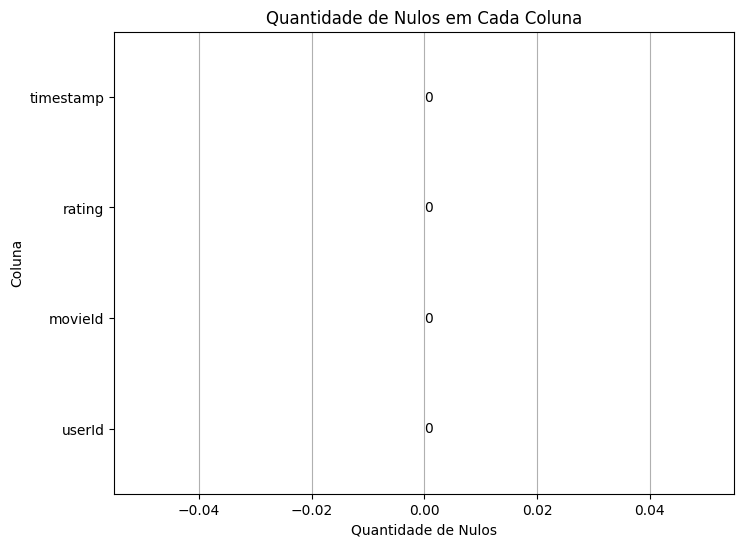

In [ ]:
quantidade_nulos = [df_ratings.filter(F.col(coluna).isNull()).count() for coluna in df_ratings.columns]
nomes_colunas = df_ratings.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

### Um usuário pode avaliar duas vezes um mesmo filme?

In [ ]:
df_ratings.printSchema()

root
 |-- userId: string (nullable = true)
 |-- movieId: string (nullable = true)
 |-- rating: string (nullable = true)
 |-- timestamp: string (nullable = true)



In [ ]:
nova_instancia = [('1','31','2.5','1260759144')]
df_nova_instancia = spark.createDataFrame(nova_instancia, ['userId','movieId','rating','timestamp'])

df_repet = df_ratings.union(df_nova_instancia)

In [ ]:
w = Window().partitionBy('userId', 'movieId')

df_repet = (
    df_repet
    .withColumn("count_repet", F.count('*').over(w))
    .filter(F.col("count_repet") > 1)
)

In [ ]:
df_repet.show(truncate=False)

+------+-------+------+----------+-----------+
|userId|movieId|rating|timestamp |count_repet|
+------+-------+------+----------+-----------+
|1     |31     |2.5   |1260759144|2          |
|1     |31     |2.5   |1260759144|2          |
+------+-------+------+----------+-----------+



## Movies

In [ ]:
df_movies_small = (
    df_ratings
    .select('movieId')
    .join(df_links.select('movieId','imdbId'),on=['movieId'],how='inner')
    .dropDuplicates(["imdbId"])
    .withColumn("imdb_id", F.concat(F.lit("tt"), F.col("imdbId"))) # ??? pq vei
    .join(df_movies,on=['imdb_id'],how='inner')
    .drop('movieId','imdbId')
)

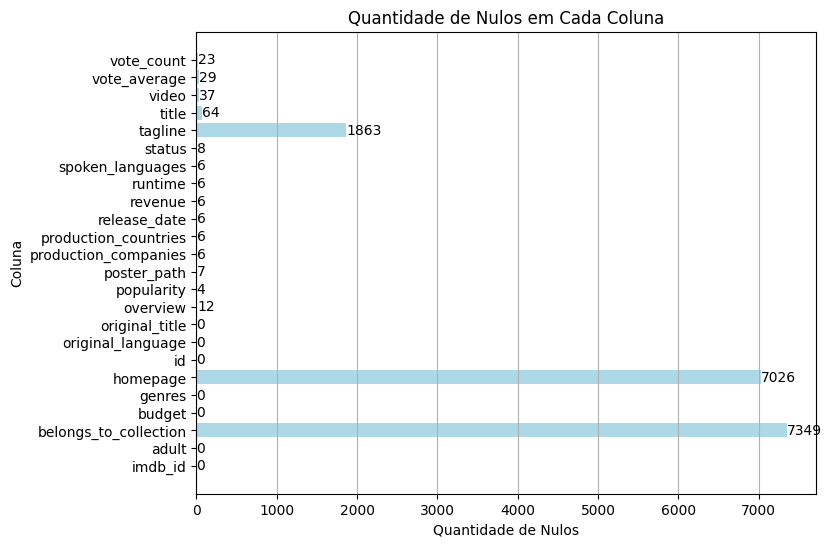

In [ ]:
quantidade_nulos = [df_movies_small.filter(F.col(coluna).isNull()).count() for coluna in df_movies_small.columns]
nomes_colunas = df_movies_small.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

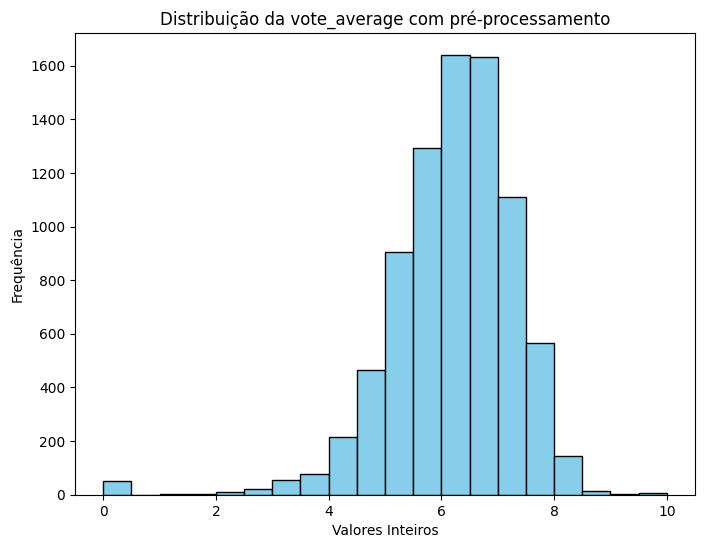

In [ ]:
import matplotlib.pyplot as plt

# Extraia a coluna desejada do DataFrame e converta para um objeto Pandas
df = (
  df_movies_small
  .select('vote_average')
  .dropna()
  .filter(F.col('vote_average').cast("float").isNotNull())
  .filter((F.col('vote_average') >= 0) & (F.col('vote_average') <= 10))
  .withColumn("vote_average", F.when(F.round(F.col("vote_average") * 2) / 2 <= F.col("vote_average"), F.round(F.col("vote_average") * 2) / 2)
  .otherwise(((F.col("vote_average") * 2) - 1) / 2))
  .orderBy(F.col('vote_average').asc())
)
coluna_desejada = df.select('vote_average').toPandas()

coluna_desejada_sem_nulos = coluna_desejada.dropna()


# Crie o histograma usando o Matplotlib com menos bins e rótulos de ticks inteiros no eixo x
plt.figure(figsize=(8, 6))
plt.hist(coluna_desejada_sem_nulos['vote_average'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Valores Inteiros')
plt.ylabel('Frequência')
plt.title('Distribuição da vote_average com pré-processamento')
plt.show()

In [ ]:
print("sem tratar o dado: {}".format(df_movies_small.select('vote_average').count()))
print("Tratando o dado: {}".format(df.select('vote_average').count()))



sem tratar o dado: 8963
Tratando o dado: 8218


In [ ]:
(
  df_movies_small
  .select('vote_average')
  .dropna()
  .filter(F.col('vote_average').cast("float").isNotNull())
  .filter((F.col('vote_average') >= 0) & (F.col('vote_average') <= 10))
  .orderBy(F.col('vote_average').desc())
).show()

+------------+
|vote_average|
+------------+
|         9.2|
|         9.0|
|         9.0|
|         9.0|
|         8.8|
|         8.7|
|         8.7|
|         8.7|
|         8.7|
|         8.7|
|         8.6|
|         8.6|
|         8.5|
|         8.5|
|         8.5|
|         8.5|
|         8.5|
|         8.5|
|         8.5|
|         8.5|
+------------+
only showing top 20 rows



## Credits

In [ ]:
df_credits_small = (
    df_ratings
    .select('movieId')
    .join(df_links.select('movieId','tmdbId'),on=['movieId'],how='inner')
    .dropDuplicates(["tmdbId"])
    .join(df_credits.withColumnRenamed('id','tmdbId'),on=['tmdbId'],how='inner')
    .drop('movieId','tmdbId')
)

df_credits_small.show(truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

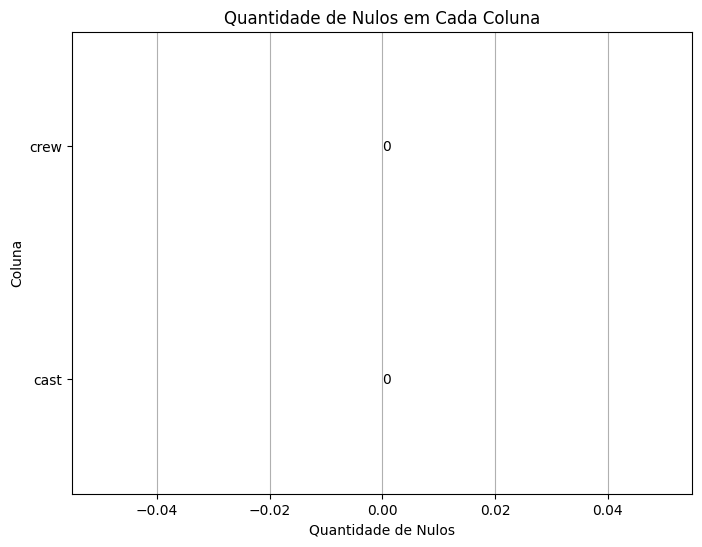

In [ ]:
quantidade_nulos = [df_credits_small.filter(F.col(coluna).isNull()).count() for coluna in df_credits_small.columns]
nomes_colunas = df_credits_small.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

## Links

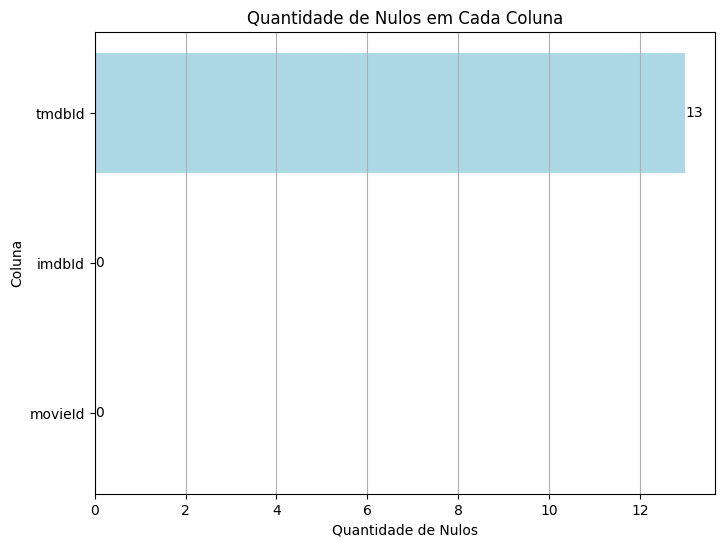

In [ ]:
quantidade_nulos = [df_links.filter(F.col(coluna).isNull()).count() for coluna in df_links.columns]
nomes_colunas = df_links.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

## Keywords

In [ ]:
df_keywords_small = (
    df_ratings
    .select('movieId')
    .join(df_links.select('movieId','tmdbId'),on=['movieId'],how='inner')
    .dropDuplicates(["tmdbId"])
    .join(df_keywords.withColumnRenamed('id','tmdbId'),on=['tmdbId'],how='inner')
    .drop('movieId','tmdbId')
)

df_keywords_small.show(truncate=False)

+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|keywords                                              

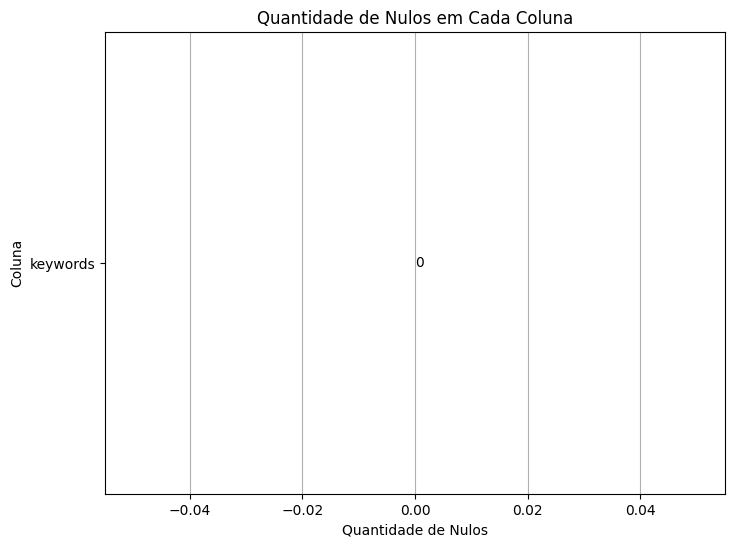

In [ ]:
quantidade_nulos = [df_keywords_small.filter(F.col(coluna).isNull()).count() for coluna in df_keywords_small.columns]
nomes_colunas = df_keywords_small.columns

plt.figure(figsize=(8, 6))
plt.barh(nomes_colunas, quantidade_nulos, color='lightblue')
plt.xlabel('Quantidade de Nulos')
plt.ylabel('Coluna')
plt.title('Quantidade de Nulos em Cada Coluna')
plt.grid(axis='x')

for i in range(len(nomes_colunas)):
    plt.text(quantidade_nulos[i], i, str(quantidade_nulos[i]), va='center')
plt.yticks(np.arange(len(nomes_colunas)), nomes_colunas)
plt.show()

## Teste

In [2]:
df_key = df_keywords_small

schema = T.ArrayType(T.StructType([
    T.StructField("id", T.StringType(), True),
    T.StructField("name", T.StringType(), True)
]))

df_key = (
    df_key
    .withColumn("keywords_array", F.from_json("keywords", schema))
    .withColumn("keywords_explode", F.explode("keywords_array"))
    .select('id', F.col("keywords_explode.id").alias("id_keyword"),  F.col("keywords_explode.name").alias("name_keyword"))
)

NameError: name 'df_keywords_small' is not defined